<a href="https://colab.research.google.com/github/Shubhranshu-Shekhar/notebook-collections/blob/master/KDD_PINNS_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade neural_tangents

**Solving a simple partial differential equation (PDE) using physics informed neural networks**

A simple PINN model for the 1D Poisson equation:  
$$-u_{xx}(x) = f(x), \quad x \in [0,1]$$

subject to boudanry conditions:  
$$ u(0) = u(1) = 0, \quad t \in [0,1].$$

We will also validate our model's predictions using a fabricated analytical solution to this PDE that can be obtained by choosing:  $$ u(x) = e^{-\frac{1}{2}x}\sin(6 \pi x),$$ 

$$ f(x) = -\frac{1}{2}e^{-\frac{1}{2}x}\sin(6 \pi x) + 6\pi e^{-\frac{1}{2}x}\cos(6 \pi x).$$

In [ ]:
import jax.numpy as np
from jax import random, jit, grad, vmap
from jax.experimental import optimizers

from jax import jacobian, eval_shape
from jax.tree_util import tree_map, tree_multimap, tree_reduce
from jax.flatten_util import ravel_pytree
import neural_tangents as nt
import operator

from functools import partial
from torch.utils import data
import itertools
from tqdm import trange
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def MLP(layers):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, k2 = random.split(key)
            glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev*random.normal(k1, (d_in, d_out))
            b = np.zeros(d_out)
            return W, b
        key, *keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params
    def apply(params, inputs):
        for W, b in params[:-1]:
            outputs = np.dot(inputs, W) + b
            inputs = np.tanh(outputs)
        W, b = params[-1]
        outputs = np.dot(inputs, W) + b
        return outputs
    return init, apply

In [ ]:
class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = (dim) if dim > 1 else ()
        self.coords = coords
        self.func = func
        self.name = name
    
    def sample(self, N, key = random.PRNGKey(1234)):
        x = self.coords.min(1) + (self.coords.max(1)-self.coords.min(1))*random.uniform(key, (N,) + self.dim)
        y = vmap(self.func)(x)
        return x, y

In [ ]:
class DataGenerator(data.Dataset):
    def __init__(self, bcs_sampler, res_sampler, mu_X = 0.0, sigma_X = 1.0, batch_size=64):
        'Initialization'
        self.mu_X = mu_X
        self.sigma_X = sigma_X
        self.bcs_sampler = bcs_sampler
        self.res_sampler = res_sampler
        self.batch_size = batch_size
        self.key = random.PRNGKey(1234)

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        X, y = self.__data_generation(subkey)
        return X, y

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        X_bc1, Y_bc1 = self.bcs_sampler[0].sample(self.batch_size//2, key)
        X_bc2, Y_bc2 = self.bcs_sampler[1].sample(self.batch_size//2, key)
        X_res, Y_res = self.res_sampler.sample(self.batch_size, key)    
        # Normalize
        X_bc1 = (X_bc1 - self.mu_X)/self.sigma_X
        X_bc2 = (X_bc2 - self.mu_X)/self.sigma_X
        X_res = (X_res - self.mu_X)/self.sigma_X
               
        inputs  = [X_bc1, X_bc2, X_res]
        outputs = [Y_bc1, Y_bc2, Y_res]
        return inputs, outputs

In [ ]:
# Helper functions for computing Jacobian dot products with PyTrees
def sum_and_contract(j1, j2, output_ndim):
    _diagonal_axes = nt.utils.utils.canonicalize_axis((), output_ndim)
    _trace_axes = nt.utils.utils.canonicalize_axis((-1,), output_ndim)
    def contract(x, y):
        param_axes = list(range(x.ndim))[output_ndim:]
        contract_axes = _trace_axes + param_axes
        return nt.utils.utils.dot_general(x, y, contract_axes, _diagonal_axes)
    return tree_reduce(operator.add, tree_multimap(contract, j1, j2))

# computes the NTK: <jac(f1)(x1), jac(f2)(x2)>
def compute_ntk(f1, f2, x1, x2, params):
    j1 = jacobian(f1)(params, *x1)
    j2 = jacobian(f2)(params, *x2)
    fx1 = eval_shape(f1, params, *x1)
    ntk = sum_and_contract(j1, j2, fx1.ndim)
    return ntk

In [ ]:
class Poisson1D:
    # Initialize the class
    def __init__(self, layers, mu_X = 0.0, sigma_X = 1.0, rng_key = random.PRNGKey(0)):
        
        # Normalization constants
        self.mu_X, self.sigma_X = mu_X, sigma_X
                 
        # Use stax to set up network initialization and evaluation functions
        self.net_init, self.net_apply = MLP(layers)
        
        # Initialize parameters, not committing to a batch shape
        self.net_params = self.net_init(rng_key)
                    
        # Optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                       decay_steps=1000, 
                                                                       decay_rate=0.99))
        self.opt_state = self.opt_init(self.net_params)


        # Logger
        self.itercount = itertools.count()
        self.loss_log_u = []
        self.loss_log_r = []
        self.weights_log = []
        
    # Make sure this accepts a single input and returns a scalar!
    # Then use vmap to vectorize
    def net_u(self, params, x):
        inputs = np.stack([x])
        u = self.net_apply(params, inputs)
        return u[0]
    
    def net_r(self, params, x):
        u_xx = grad(grad(self.net_u, 1), 1)(params, x)
        res = -u_xx/self.sigma_X**2
        return res
        
    def loss_u(self, params, batch):
        # Fetch data
        inputs, targets = batch
        X_bc1, X_bc2, _ = inputs
        Y_bc1, Y_bc2, _ = targets
        # Evaluate model
        u_fn = lambda x: self.net_u(params, x)
        u_bc1 = vmap(u_fn)(X_bc1)
        u_bc2 = vmap(u_fn)(X_bc2)
        # Compute loss
        loss_bc1 = np.mean((Y_bc1 - u_bc1)**2)
        loss_bc2 = np.mean((Y_bc2 - u_bc2)**2)
        loss_u = loss_bc1 + loss_bc2
        return loss_u
    
    def loss_r(self, params, batch):
        # Fetch data
        inputs, targets = batch
        _, _, X_res = inputs
        _, _, Y_res = targets
        # Evaluate residual
        r_fn = lambda x: self.net_r(params, x)
        res = vmap(r_fn)(X_res)
        # Compute loss
        loss_r = np.mean((Y_res - res)**2)
        return loss_r

    def loss(self, params, batch, weights=(1.0,1.0)):
        w_u, w_r = weights
        loss_u = self.loss_u(params, batch)
        loss_r = self.loss_r(params, batch)
        loss = w_u*loss_u + w_r*loss_r
        return loss
    
    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, batch, weights):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, batch, weights)
        return self.opt_update(i, g, opt_state)
    
    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000, ntk_weights = False):
        data = iter(dataset)
        pbar = trange(nIter)
        # Initialize NTK weights
        if ntk_weights:
            params = self.get_params(self.opt_state)
            batch = next(data)
            weights = self.update_NTK_weights(params, batch)
            self.weights_log.append(weights)
        else:
            weights = (1.0, 1.0)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.opt_state = self.step(next(self.itercount), self.opt_state, batch, weights)
            # Logger
            if it % 50 == 0:
                params = self.get_params(self.opt_state)
                loss_u_value = self.loss_u(params, batch)
                loss_r_value = self.loss_r(params, batch)
                self.loss_log_u.append(loss_u_value)
                self.loss_log_r.append(loss_r_value)
                pbar.set_postfix({'Loss_u': loss_u_value, 'Loss_r': loss_r_value})
                if ntk_weights:
                    weights = self.update_NTK_weights(params, batch)
                    self.weights_log.append(weights)
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict(self, params, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        u_fn = lambda x: self.net_u(params, x)
        u_star = vmap(u_fn)(X_star)
        return u_star

    @partial(jit, static_argnums=(0,))
    def residual(self, params, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        r_fn = lambda x: self.net_r(params, x)
        r_star = vmap(r_fn)(X_star)
        return r_star

    @partial(jit, static_argnums=(0,))
    def update_NTK_weights(self, params, batch):
        inputs, _ = batch
        X_bc1, X_bc2, X_res = inputs
        X_bcs = np.concatenate([X_bc1, X_bc2], axis = 0)
        diag_u = vmap(grad(self.net_u), in_axes = (None,0))(params, X_bcs)
        diag_r = vmap(grad(self.net_r), in_axes = (None,0))(params, X_res)
        diag_u, _ = ravel_pytree(diag_u)
        diag_r, _ = ravel_pytree(diag_r)
        trace_u = np.dot(diag_u, diag_u)
        trace_r = np.dot(diag_r, diag_r)
        T = trace_u + trace_r
        w_u = T/trace_u
        w_r = T/trace_r
        return w_u, w_r

    @partial(jit, static_argnums=(0,))
    def compute_NTK_spectrum(self, params, batch):
        inputs, _ = batch
        X_bc1, X_bc2, X_res = inputs
        X_bcs = np.concatenate([X_bc1, X_bc2], axis = 0)
        X_bcs = (X_bcs - self.mu_X)/self.sigma_X
        X_res = (X_res - self.mu_X)/self.sigma_X
        u_fn = lambda p, x: vmap(self.net_u, in_axes=(None,0))(p, x)[:,None]
        r_fn = lambda p, x: vmap(self.net_r, in_axes=(None,0))(p, x)[:,None]
        # Construct NKT operator
        K_uu = compute_ntk(u_fn, u_fn, (X_bcs,), (X_bcs,), params)
        K_ur = compute_ntk(u_fn, r_fn, (X_bcs,), (X_res,), params)
        K_rr = compute_ntk(r_fn, r_fn, (X_res,), (X_res,), params)
        K = np.concatenate([np.concatenate([K_uu, K_ur], axis = 1),
                            np.concatenate([K_ur.T, K_rr], axis = 1)], axis = 0)
        # Spectral decomposition
        v, w = np.linalg.eigh(K)
        # Sort eigenvalues
        idx = np.argsort(v)[::-1]
        evals = v[idx]
        evecs = w[:,idx]
        return evals, evecs

In [ ]:
# Reference solution for -u_xx = f(x)
def u(x):
    return 4.0*np.exp(-0.5*x**2) * np.sin(6.0*np.pi*x)

def f(x):
    u_xx = grad(grad(u))(x)
    return -u_xx

In [ ]:
# Samplers
dim = 1

# Domain boundaries
bc1_coords = np.array([[0.0, 0.0]])
bc2_coords = np.array([[1.0, 1.0]])
dom_coords = np.array([[0.0, 1.0]])

# Create boundary conditions samplers
bc1 = Sampler(dim, bc1_coords, lambda x: u(x), name = 'Dirichlet BC1')
bc2 = Sampler(dim, bc2_coords, lambda x: u(x), name = 'Dirichlet BC2')
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(dim, dom_coords, lambda x: f(x), name = 'Residual')

# Normalize inputs
X, _ = res_sampler.sample(np.int32(1e5))
mu_X, sigma_X = X.mean(0), X.std(0)

dataset = DataGenerator(bcs_sampler, res_sampler, mu_X, sigma_X, batch_size=256)

# Test data
n_star = 1000
x_star = np.linspace(0, 1, n_star)
u_star = vmap(u)(x_star)
f_star = vmap(f)(x_star)

In [ ]:
# Model
init_key = random.PRNGKey(0)
layers = [1, 64, 64, 1]
model = Poisson1D(layers, mu_X, sigma_X, rng_key=init_key)

In [ ]:
ntk_weights=True
model.train(dataset, nIter = 40000, ntk_weights = ntk_weights)

 78%|███████▊  | 31346/40000 [01:18<00:21, 399.26it/s, Loss_u=4.3367763e-06, Loss_r=10.3409605]


KeyboardInterrupt: ignored

In [ ]:
# Predict
opt_params = model.get_params(model.opt_state)
u_pred = model.predict(opt_params, x_star)
r_pred = model.residual(opt_params, x_star)
error_u = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 1.435468e-03


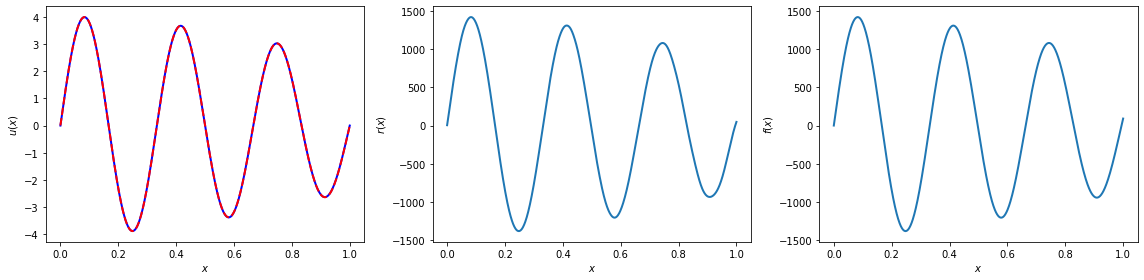

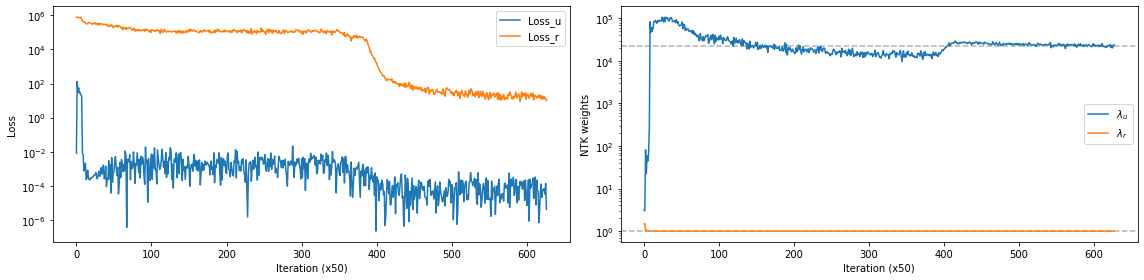

In [ ]:
plt.figure(figsize = (16,4))    
plt.subplot(1,3,1)    
plt.plot(x_star, u_star, 'b-', linewidth = 2)
plt.plot(x_star, u_pred, 'r--', linewidth = 2)
plt.xlabel('$x$')
plt.ylabel('$u(x)$')
plt.tight_layout()

plt.subplot(1,3,2)    
plt.plot(x_star, r_pred, linewidth = 2)
plt.xlabel('$x$')
plt.ylabel('$r(x)$')
plt.tight_layout()

plt.subplot(1,3,3)    
plt.plot(x_star, f_star, linewidth = 2)
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.tight_layout()

plt.figure(figsize = (16,4))
plt.subplot(1,2,1)
plt.plot(model.loss_log_u, label='Loss_u')
plt.plot(model.loss_log_r, label='Loss_r')
plt.xlabel('Iteration (x50)')
plt.ylabel('Loss')
plt.legend()
plt.yscale('log')
plt.subplot(1,2,2)
if ntk_weights:
    weights = np.array(model.weights_log)
else: 
    weights = np.ones((len(model.loss_log_u), 2))
plt.axhline(1.0, color='gray', linestyle = '--', alpha = 0.6)
plt.axhline(np.mean(weights[-20:,0]), color='gray', linestyle = '--', alpha = 0.6)
plt.plot(weights[:,0], label='$\lambda_u$')
plt.plot(weights[:,1], label='$\lambda_r$')
plt.xlabel('Iteration (x50)')
plt.ylabel('NTK weights')
plt.yscale('log')
plt.legend()
plt.tight_layout()